#Check volumi Perpetual e Spot

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , mean_squared_error , mean_absolute_error , classification_report, log_loss, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LinearRegression, ElasticNet, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import seaborn as sns
import time
import cvxpy as cp
from scipy.optimize import minimize
import yfinance as yf
%load_ext autoreload
%autoreload 2

(CVXPY) May 02 01:10:20 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/miniconda3/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /opt/miniconda3/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/miniconda3/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/miniconda3/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/miniconda3/bin/../lib/liblapack.3.dylib' (no such file), '/opt/miniconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


## Parametri

In [2]:
##storico totale
start_date  = '2001-01-01'
end_date    = '2023-06-30'
resample    = 'D'
stock_symb  = 'SPY'

In [3]:
my_factors = 'NG=F, CL=F, GC=F, GOVT, QQQ, ^VIX, ^GDAXI, EURUSD=X, USDJPY=X'

my_factors = yf.download(my_factors,start=start_date, end=end_date)['Adj Close']
my_factors = np.log1p(my_factors.pct_change())

[*********************100%***********************]  9 of 9 completed


/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [4]:
stock = yf.download(stock_symb,start=start_date, end=end_date)['Adj Close']
stock = np.log1p(stock.pct_change())
stock.name = stock_symb

[*********************100%***********************]  1 of 1 completed


In [5]:
vix = yf.download('^VIX',start=start_date, end=end_date)['Adj Close']
vix.name = 'VIX'

[*********************100%***********************]  1 of 1 completed


,CL=F,EURUSD=X,GC=F,GOVT,NG=F,QQQ,USDJPY=X,^GDAXI,^VIX,SPY
Date,,,,,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,-0.001485,NaN,NaN,NaN
2001-01-03,0.027200,NaN,-0.001491,NaN,-0.017367,0.155653,-0.004907,0.022813,-0.119953,0.046918
2001-01-04,0.008905,NaN,-0.002615,NaN,0.090654,-0.018182,0.019572,-0.009120,0.013814,-0.010822
2001-01-05,-0.007117,NaN,0.002615,NaN,0.027399,-0.079533,0.003096,0.000904,0.061126,-0.033188
...,...,...,...,...,...,...,...,...,...,...
2023-04-26,-0.036603,-0.007361,-0.004171,-0.003831,-0.085948,0.006046,-0.002786,-0.004825,0.004255,-0.004245
2023-04-27,0.006172,0.006255,0.002113,-0.005559,0.106541,0.026828,-0.001841,0.000299,-0.101006,0.019712
2023-04-28,0.026661,-0.001380,0.000100,0.005133,0.023086,0.006875,0.002522,0.007687,-0.076233,0.008499


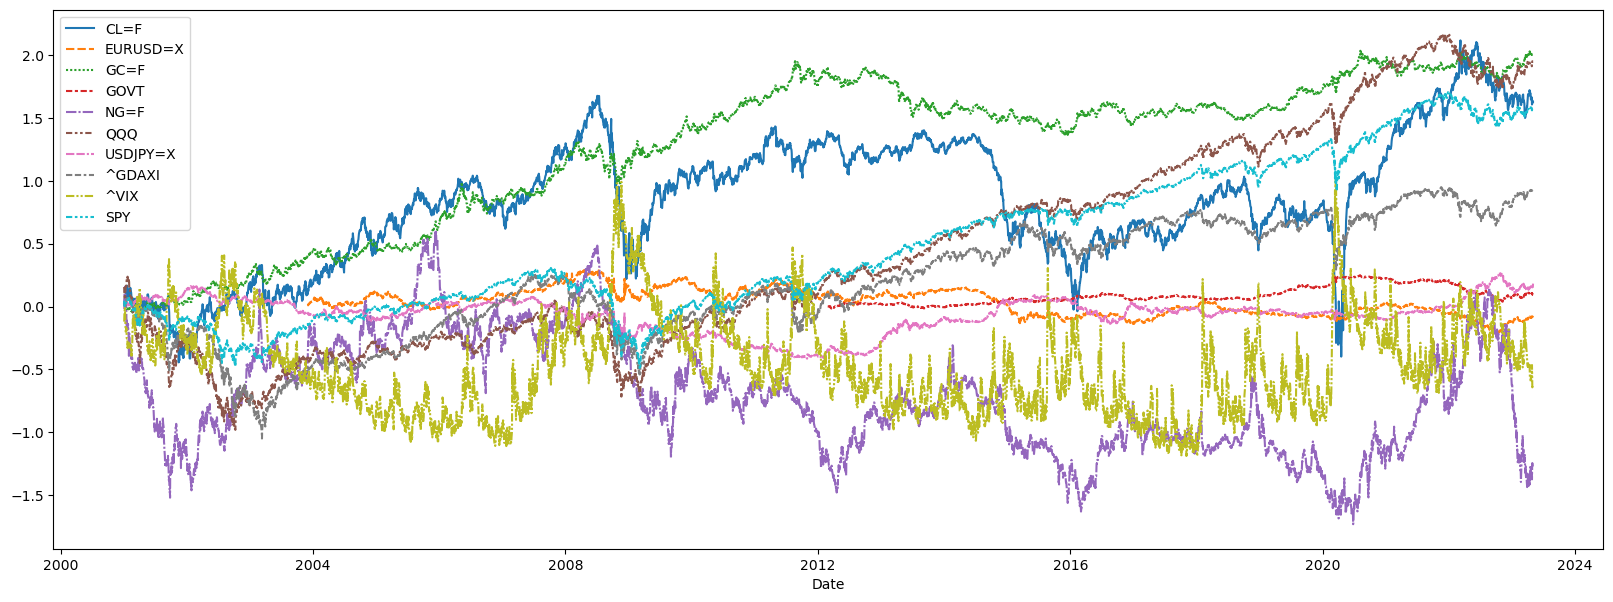

In [6]:
data = pd.concat([my_factors, stock], axis=1)
# data['SPY'] = data['SPY'].shift(-1)
plt.figure(figsize=(20,7))
sns.lineplot(data.cumsum())
# data.cumsum().plot()
data

## Utility Functions

In [7]:
def create_options():
    '''create standard options dictionary to be used as input to regression functions'''
    options = dict()
    options['time_period'] = 'all'
    options['date'] = 'Date'
    options['return_model'] = False
    options['print_loadings'] = True
    return options

def create_options_lasso():
    options = create_options()
    options['lambda_hat'] = .5
    return options

def create_options_cv_lasso():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['n_lambda_hat'] = 200
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_ridge():
    options = create_options()
    options['max_lambda'] = 1
    options['n_lambda'] = 100
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_cv_elastic_net():
    options = create_options()
    options['max_lambda_hat'] = 1
    options['max_l1_ratio'] = .99
    options['n_lambda_hat'] = 100
    options['n_l1_ratio'] = 20
    options['random_state'] = 7777
    options['n_folds'] = 10
    return options

def create_options_best_subset():
    '''create standard options dictionary to be used as input to regression functions'''
    options = create_options()
    options['return_model'] = False
    options['print_loadings'] = True
    options['max_vars'] = 3
    return options

def num_to_month(month):
    #num to month returns the name of the month, input is an integer
    if (month==1):
        return 'January'
    if (month==2):
        return 'Febuary'
    if (month==3):
        return 'March'
    if (month==4):
        return 'April'
    if (month==5):
        return 'May'
    if (month==6):
        return 'June'
    if (month==7):
        return 'July'
    if (month==8):
        return 'August'
    if (month==9):
        return 'September'
    if (month==10):
        return 'October'
    if (month==11):
        return 'November'
    if (month==12):
        return 'December'

def display_factor_loadings(intercept, coefs, factorNames, options):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    if('name_of_reg' not in options.keys()):
        name = 'No Name'
    else:
        name = options['name_of_reg']
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    print(out)

def print_timeperiod(data, dependentVar, options):
    '''print_timeperiod takes a a dependent varaible and a options dictionary, prints out the time period
    INPUTS:
        data: pandas df, df with the data
        dependentVar: string, name of dependent variable
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
    OUTPUTS:
        printed stuff
    '''
    print ('Dependent Variable is ' + dependentVar)
    if(options['time_period'] == 'all'):
        sortedValues = data.sort_values(options['date'])[options['date']].reset_index(drop=True)
        n = sortedValues.shape[0]
        beginDate = sortedValues[0]
        endDate = sortedValues[n-1]
        print ('Time period is between ' + num_to_month(beginDate.month) +  ' ' + str(beginDate.year) + ' to ' + num_to_month(endDate.month) +  ' ' + str(endDate.year) + ' inclusive   ')        
    else:
        print ('Time period is ' + options['timeperiod'])

def linear_regression(data, dependentVar, factorNames, options):
    '''linear_regression takes in a dataset and returns the factor loadings using least squares regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    linReg = LinearRegression(fit_intercept=True)
    linReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        # Now print the factor loadings
        display_factor_loadings(linReg.intercept_, linReg.coef_, factorNames, options)

    if(options['return_model']):
        return linReg
      
def lasso_regression(data, dependentVar, factorNames, options):
    '''lasso_regression takes in a dataset and returns the factor loadings using lasso regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            printLoadings: boolean, if true, prints the coeficients

            date: name of datecol
            returnModel: boolean, if true, returns model
            alpha: float, alpha value for LASSO regression
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    if('lambda_hat' not in options.keys()):
        print ('lambda_hat not specified in options')
        return

    #first filter down to the time period
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    lassoReg = Lasso(alpha=options['lambda_hat'], fit_intercept=True)
    lassoReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('lambda_hat = ' + str(options['lambda_hat']))

        #Now print the factor loadings
        display_factor_loadings(lassoReg.intercept_, lassoReg.coef_, factorNames, options)
        
def cross_validated_lasso_regression(data, dependentVar, factorNames, options):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphas = np.logspace(-12, np.log(options['max_lambda_hat']), base=np.exp(1), num=options['n_lambda_hat'])
    #alphas = np.linspace(1e-12, alphaMax, options['nAlphas'])
    if(options['random_state'] == 'none'):
        lassoTest = Lasso(fit_intercept=True)
    else:
        lassoTest = Lasso(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(lassoTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    lassoBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(lassoBest.intercept_, lassoBest.coef_, factorNames, options)

    if(options['return_model']):
        return lassoBest
    
def cross_validated_ridge_regression(data, dependentVar, factorNames, options):
    '''cross_validated_ridge_regression takes in a dataset and returns the factor loadings using ridge regression and choosing lambda via ridge regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda'], base=np.exp(1))
    if(options['randomState'] == 'none'):
        ridgeTest = Ridge(fit_intercept=True)
    else:
        ridgeTest = Ridge(random_state = options['randomState'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(ridgeTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    ridgeBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best Lambda = ' + str(alphaBest))
        #Now print the factor loadings
        display_factor_loadings(ridgeBest.intercept_, ridgeBest.coef_, factorNames, options)

    if(options['return_model']):
        return ridgeBest

def cross_validated_elastic_net_regression(data, dependentVar, factorNames, options):
    '''cross_validated_elastic_net_regression takes in a dataset and returns the factor loadings using elastic net, also chooses alpha and l1 ratio via cross validation
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            maxL1Ratio: float
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #Do CV Lasso
    alphaMax = options['max_lambda_hat']
    alphas = np.logspace(-12, np.log(alphaMax), num=options['n_lambda_hat'])
    l1RatioMax = options['max_l1_ratio']
    l1Ratios = np.linspace(1e-6, l1RatioMax, options['n_l1_ratio'])
    if(options['random_state'] == 'none'):
        elasticNetTest = ElasticNet(fit_intercept=True)
    else:
        elasticNetTest = ElasticNet(random_state = options['random_state'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas, 'l1_ratio': l1Ratios}]

    clf = GridSearchCV(elasticNetTest, tuned_parameters, cv=options['n_folds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    elasticNetBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']
    l1RatioBest = clf.best_params_['l1_ratio']

    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Best lambda_hat = ' + str(alphaBest))
        print('Best l1 ratio = ' + str(l1RatioBest))
        #Now print the factor loadings
        display_factor_loadings(elasticNetBest.intercept_, elasticNetBest.coef_, factorNames, options)

    if(options['return_model']):
        return elasticNetBest

def best_subset(x,y,l_0):
    # Mixed Integer Programming in feature selection
    M = 1000
    n_factor = x.shape[1]
    z = cp.Variable(n_factor, boolean=True)
    beta = cp.Variable(n_factor)
    alpha = cp.Variable(1)

    def MIP_obj(x,y,b,a):
        return cp.norm(y-cp.matmul(x,b)-a,2)

    best_subset_prob = cp.Problem(cp.Minimize(MIP_obj(x, y, beta, alpha)), 
                             [cp.sum(z)<=l_0, beta+M*z>=0, M*z>=beta])
    best_subset_prob.solve(solver='ECOS_BB')
    return alpha.value, beta.value

def best_subset_regression(data, dependentVar, factorNames, options):
    '''best_subset_regression takes in a dataset and returns the factor loadings using best subset regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            maxVars: int, maximum number of factors that can have a non zero loading in the resulting regression
            printLoadings: boolean, if true, prints the coeficients
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Check dictionary for maxVars option
    if('max_vars' not in options.keys()):
        print ('max_vars not specified in options')
        return

    if(options['time_period'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['time_period'])

    #perform linear regression
    alpha, beta = best_subset(data[factorNames].values, data[dependentVar].values, options['max_vars'])
    #round beta values to zero
    beta[np.abs(beta) <= 1e-7] = 0.0
    
    if (options['print_loadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('Max Number of Non-Zero Variables is ' + str(options['max_vars']))

        #Now print the factor loadings
        display_factor_loadings(alpha, beta, factorNames, options)

    if(options['return_model']):
        out = LinearRegression()
        out.intercept_ = alpha[0]
        out.coef_ = beta
        return out


## DATA

In [8]:
data = data.copy()
# data.ffill(inplace=True)
data.dropna(how='any', inplace=True)
if(resample == 'W'):
    data = data.resample('W').sum()
elif(resample == 'M'):
    data = data.resample('M').sum()
data.dropna(how='any',inplace=True)
data

,CL=F,EURUSD=X,GC=F,GOVT,NG=F,QQQ,USDJPY=X,^GDAXI,^VIX,SPY
Date,,,,,,,,,,
2012-02-27,-0.011084,0.006965,-0.000845,0.000000,-0.041639,0.001406,0.019096,-0.002163,0.049588,0.001679
2012-02-28,-0.018689,-0.004501,0.007527,0.000000,0.029408,0.010097,-0.012437,0.005537,-0.012725,0.002912
2012-02-29,0.004868,0.005310,-0.044103,0.000000,0.037784,-0.004492,0.000199,-0.004591,0.025833,-0.003933
2012-03-01,0.016396,-0.011724,0.006529,0.000000,-0.060266,0.007886,0.009842,0.012421,-0.065588,0.005168
2012-03-02,-0.019858,0.000133,-0.007172,0.000000,0.008490,-0.000770,-0.001921,-0.002943,0.001737,-0.003054
...,...,...,...,...,...,...,...,...,...,...
2023-04-25,-0.021691,0.006097,0.002460,0.008533,0.014847,-0.019044,0.000918,0.000515,0.105005,-0.016001
2023-04-26,-0.036603,-0.007361,-0.004171,-0.003831,-0.085948,0.006046,-0.002786,-0.004825,0.004255,-0.004245
2023-04-27,0.006172,0.006255,0.002113,-0.005559,0.106541,0.026828,-0.001841,0.000299,-0.101006,0.019712


In [9]:
factors = data.drop(stock_symb, axis=1).columns.to_list()
data.reset_index(inplace=True)
data.rename(columns={'index':'Date'}, inplace=True)

## OLS Regression

In [10]:
options = create_options()
options['name_of_reg'] = 'OLS full data'
options['return_model'] = True
ols_model_train = linear_regression(data, stock_symb, factors, options)

Dependent Variable is SPY
Time period is between Febuary 2012 to May 2023 inclusive   
               Intercept     CL=F  EURUSD=X      GC=F      GOVT     NG=F  \
OLS full data   0.000073  0.02263  0.010602  0.017955 -0.192821  0.00463   

                    QQQ  USDJPY=X    ^GDAXI     ^VIX  
OLS full data  0.618102 -0.003208  0.106416 -0.01819  


## Penalized Regressions (Lasso , Elastic Net)

In [11]:
options = create_options_cv_lasso()
options['name_of_reg'] = 'CV Lasso'
options['max_lambda_hat'] = .01 #This specifies the maximum Alpha value tested by cross validation, minimum value is zero
options['return_model'] = True
options['n_folds'] = 5 #This states the number of folds
lasso_model_train = cross_validated_lasso_regression(data, stock_symb, factors, options)

Dependent Variable is SPY
Time period is between Febuary 2012 to May 2023 inclusive   
Best lambda_hat = 6.144212353328214e-06
          Intercept      CL=F  EURUSD=X  GC=F  GOVT      NG=F      QQQ  \
CV Lasso   0.000103  0.020928       0.0   0.0  -0.0  0.001343  0.57166   

          USDJPY=X  ^GDAXI      ^VIX  
CV Lasso      -0.0   0.077 -0.026335  


In [12]:
options = create_options_cv_elastic_net()
options['name_of_reg'] = 'CV Elastic Net'
options['max_lambda_hat'] = .01
options['return_model'] = True
options['n_folds'] = 5
en_model_train = cross_validated_elastic_net_regression(data, stock_symb, factors, options)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.348e-04, tolerance: 2.807e-05
  model = cd_fast.enet_coordinate_descent(


Dependent Variable is SPY
Time period is between Febuary 2012 to May 2023 inclusive   
Best lambda_hat = 3.1512786437703828e-06
Best l1 ratio = 0.20842184210526316
                Intercept      CL=F  EURUSD=X      GC=F      GOVT      NG=F  \
CV Elastic Net   0.000082  0.024195       0.0  0.003591 -0.077967  0.004493   

                     QQQ  USDJPY=X    ^GDAXI      ^VIX  
CV Elastic Net  0.597384      -0.0  0.107281 -0.021165  


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set
X = data[factors]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data)


    feature       VIF
0      CL=F  1.118962
1  EURUSD=X  1.138406
2      GC=F  1.120436
3      GOVT  1.172501
4      NG=F  1.015935
5       QQQ  2.133024
6  USDJPY=X  1.145167
7    ^GDAXI  1.419698
8      ^VIX  2.045760
